In [1]:
# Importing necessary librabries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# NLTK downloads for data cleaning

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sinha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sinha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
train = pd.read_csv('../Datasets/Corona_NLP_train.csv', encoding= 'latin1')
test = pd.read_csv('../Datasets/Corona_NLP_test.csv', encoding= 'latin1')

In [4]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], inplace = True, axis = 1)

In [6]:
train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [8]:
train.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [9]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

In [10]:
#Functions used for removing unnecessary texts from the dataset

import unicodedata as ucd

def remove_url(text):
    text = re.sub(r'http\S+', "", text)
    return text

def remove_mentions(text):
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text=re.sub('\[.*?\]',' ',text)
    text=re.sub(r'<.*?>',' ',text)
    text=re.sub(r'\d+',' ', text)
    text=re.sub('[^a-zA-Z]', ' ', text)

    return text

def word_tokenizer(text):
    text = text.lower()
    text = text.split()
    return text

en_stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    text = [word for word in text if word not in en_stopwords]
    return text

lemma = WordNetLemmatizer()

def lemmatization(text):
    text = [lemma.lemmatize(word) for word in text]
    return text


In [11]:
def preprocessing(text):
    text = remove_url(text)
    text = ucd.normalize('NFKD', text)
    text = remove_mentions(text)
    text = word_tokenizer(text)
    text = lemmatization(text)
    text = remove_stopwords(text)
    text = ' '.join(text)
    
    return text

In [12]:
from tqdm import tqdm
tqdm.pandas()

X_cleaned = X.progress_map(preprocessing)

100%|██████████| 41157/41157 [00:08<00:00, 5008.90it/s]


In [13]:
X_cleaned.head(10)

0                                                     
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
3    food stock one empty please panic enough food ...
4    ready go supermarket outbreak paranoid food st...
5    news regiona first confirmed covid case came s...
6    cashier grocery store wa sharing insight prove...
7                wa supermarket today buy toilet paper
8    due covid retail store classroom atlanta open ...
9    corona prevention stop buy thing cash use onli...
Name: OriginalTweet, dtype: object

Wordcloud to see the most used words in different state of tweets

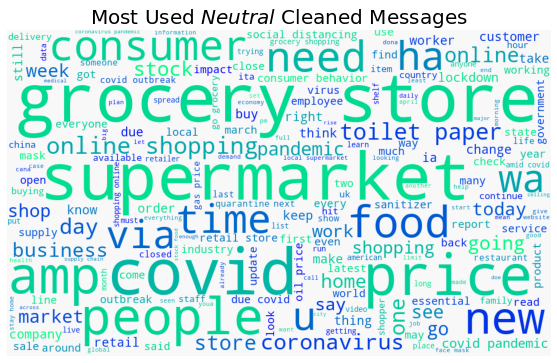

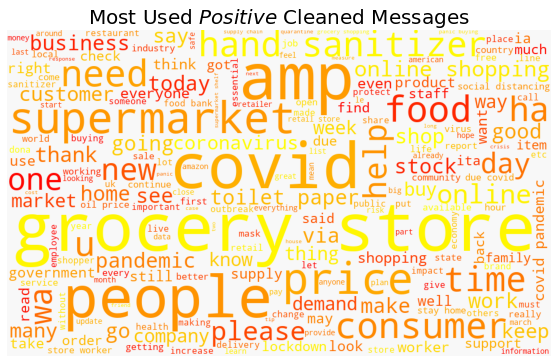

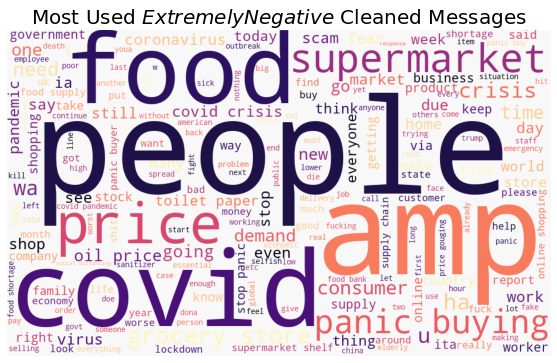

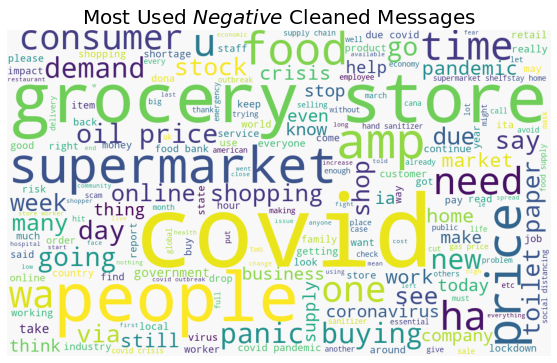

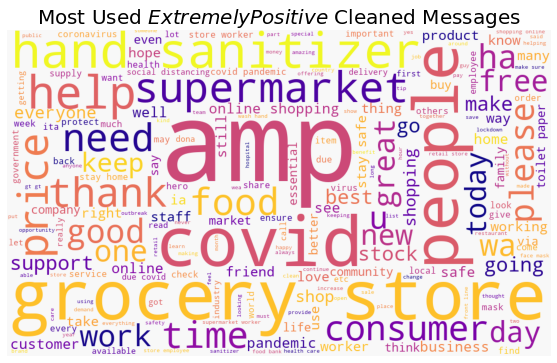

In [14]:
#Creating dataframe which will be used for creating wordcloud
data_frame=pd.DataFrame({
    'Tweets':X_cleaned,
    'Sentiment':y
})

sentiments=data_frame['Sentiment'].unique()
color_maps=['winter','autumn','magma','viridis','plasma']
for label,cmap in zip(sentiments,color_maps):
    text=data_frame.query('Sentiment==@label')['Tweets'].str.cat(sep=' ')
    plt.figure(figsize=(10,6))
    wc=WordCloud(width=1000,height=600,background_color='#f8f8f8',colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f'Most Used ${label}$ Cleaned Messages',size=20)
    plt.show()

### Modelling

In [15]:
# Importing libraries needed for modelling

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.layers as tfl

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


Prepping data to be used for modelling

In [16]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X=tokenizer.texts_to_sequences(X_cleaned)
vocab_size=len(tokenizer.word_index)+1
X=pad_sequences(X,padding='post', maxlen = 50)

In [17]:
encoding={
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Extremely Positive': 2
}
labels=['Negative','Neutral','Positive']
y.replace(encoding,inplace=True)

Setting up the hyperparameters

In [18]:
epoch = 5
batch_size = 32
validation_split = 0.12
embedding_dims = 16

RNN

In [19]:
modelRNN=tf.keras.Sequential([
    tfl.Embedding(vocab_size, embedding_dims, input_length=X.shape[1]),
    tfl.SimpleRNN(512,return_sequences=True,activation='relu'),
    tfl.SimpleRNN(512,return_sequences=True,activation='relu'),
    tfl.GlobalAveragePooling1D(),
    tfl.Dense(64,activation='relu'),
    tfl.Dropout(0.4),
    tfl.Dense(3,activation='softmax')
])
modelRNN.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])
modelRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            477664    
                                                                 
 simple_rnn (SimpleRNN)      (None, 50, 512)           270848    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 512)           524800    
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

LSTM

In [20]:
modelLSTM=tf.keras.Sequential([
    tfl.Embedding(vocab_size, embedding_dims, input_length=X.shape[1]),
    tfl.Bidirectional(tfl.LSTM(256,return_sequences=True)),
    tfl.Bidirectional(tfl.LSTM(256,return_sequences=True)),
    tfl.GlobalMaxPool1D(),
    tfl.Dropout(0.4),
    tfl.Dense(64,activation='relu'),
    tfl.Dropout(0.4),
    tfl.Dense(3,activation='softmax')
])
modelLSTM.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            477664    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 512)          559104    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 512)          1574912   
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

Training the models

In [22]:
print('Recurrent Neural Network Model:\n')
RNN = modelRNN.fit(X, y, epochs = epoch, validation_split = validation_split, batch_size = batch_size)
print('\nLong Short Term Memory Model:\n')
LSTM = modelLSTM.fit(X, y, epochs = epoch, validation_split = validation_split, batch_size = batch_size)

Recurrent Neural Network Model:

Epoch 1/5
1132/1132 [==============================] - 123s 108ms/step - loss: 0.8202 - accuracy: 0.6236 - val_loss: 0.5457 - val_accuracy: 0.7975
Epoch 2/5
1132/1132 [==============================] - 126s 112ms/step - loss: 0.4461 - accuracy: 0.8503 - val_loss: 0.4044 - val_accuracy: 0.8633
Epoch 3/5
1132/1132 [==============================] - 126s 112ms/step - loss: 0.3092 - accuracy: 0.9049 - val_loss: 0.4236 - val_accuracy: 0.8573
Epoch 4/5
1132/1132 [==============================] - 126s 112ms/step - loss: 0.2432 - accuracy: 0.9265 - val_loss: 0.4629 - val_accuracy: 0.8504
Epoch 5/5
1132/1132 [==============================] - 127s 112ms/step - loss: 0.2023 - accuracy: 0.9390 - val_loss: 0.5285 - val_accuracy: 0.8421

Long Short Term Memory Model:

Epoch 1/5
1132/1132 [==============================] - 40s 30ms/step - loss: 0.7262 - accuracy: 0.6730 - val_loss: 0.4385 - val_accuracy: 0.8514
Epoch 2/5
1132/1132 [==============================] - 

In [23]:
history={'RNN':RNN, 'LSTM':LSTM}

In [24]:
model_names=['Recurrent Neural Network', 'Long Short Term Memory' ]

Testing the models on test dataset

In [25]:
tqdm.pandas()

X_test=test['OriginalTweet'].progress_map(preprocessing)
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test,padding='post', maxlen=50)
y_test = test['Sentiment']
y_test.replace(encoding,inplace=True)

100%|██████████| 3798/3798 [00:00<00:00, 5456.23it/s]


In [26]:
models={'RNN':modelRNN, 'LSTM':modelLSTM}

In [27]:
classes={}
for i,model in enumerate(models):
    prediction=models[model].predict(X_test)
    classes[model]=np.argmax(prediction,axis=1)

119/119 [==============================] - 3s 12ms/step


In [28]:
classes

{'RNN': array([0, 2, 2, ..., 1, 0, 2], dtype=int64),
 'LSTM': array([0, 2, 2, ..., 1, 0, 2], dtype=int64)}

Test loss and accuracy of both models

In [30]:
for i,model in enumerate(models):
    print(model)
    loss,accuracy=models[model].evaluate(X_test,y_test,verbose=0)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}\n')

RNN
Test Loss: 0.5976578593254089
Test Accuracy: 0.8299104571342468

LSTM
Test Loss: 0.6468203663825989
Test Accuracy: 0.8320168256759644

